In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
IMG_SIZE= (224, 224)
N_CLASSES= 7

In [26]:
df= pd.read_csv('paths.csv')

In [27]:
df['image'] = df['image'].str.replace(
    '/kaggle/input/street-objects/', 
    '', 
    regex=False
)

In [28]:
df['label'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [29]:
df['label']= df['label'].astype('string')

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
df_trn, df_tmp= train_test_split(df,     test_size=0.3, random_state=42, shuffle=True, stratify=df['label'])
df_vld, df_tst= train_test_split(df_tmp, test_size=0.4, random_state=42, shuffle=True, stratify=df_tmp['label'])

print(f"Training:   {len(df_trn):4d} images")
print(f"Validation: {len(df_vld):4d} images")
print(f"Test:       {len(df_tst):4d} images")

Training:   6915 images
Validation: 1778 images
Test:       1186 images


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models              import Sequential
from tensorflow.keras.layers              import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers          import Adamax
from tensorflow.keras.callbacks		      import EarlyStopping

In [33]:
BATCH_SIZE= 16
EPOCHS= 10
LEARN_RATE= 1e-3

In [34]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [36]:
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE) 
    img = img / 255.0  
    return img, label

In [37]:
def create_tf_dataset(df, batch_size):
    paths = df['image'].values  
    labels = df['label'].values
    labels = to_categorical(labels, num_classes=N_CLASSES)  
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


In [38]:
train_dataset = create_tf_dataset(df_trn, BATCH_SIZE)
validation_dataset = create_tf_dataset(df_vld, BATCH_SIZE)
test_dataset = create_tf_dataset(df_tst, BATCH_SIZE)

In [39]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [40]:
model = create_cnn_model((IMG_SIZE[0], IMG_SIZE[1], 3), N_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c:\Users\Asus\Downloads\StreetObjectClassification\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)

Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 78s 162ms/step - accuracy: 0.6513 - loss: 1.0410 - val_accuracy: 0.7801 - val_loss: 0.6182
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 124s 281ms/step - accuracy: 0.7828 - loss: 0.6543 - val_accuracy: 0.8195 - val_loss: 0.4877
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 112s 254ms/step - accuracy: 0.8346 - loss: 0.4906 - val_accuracy: 0.8228 - val_loss: 0.5277
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 118s 268ms/step - accuracy: 0.8602 - loss: 0.4148 - val_accuracy: 0.8515 - val_loss: 0.4530
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 128s 292ms/step - accuracy: 0.8868 - loss: 0.3366 - val_accuracy: 0.8633 - val_loss: 0.4025
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 142s 325ms/step - accuracy: 0.9112 - loss: 0.2676 - val_accuracy: 0.8847 - val_loss: 0.4548
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 133s 303ms/step - accuracy: 0.9215 - loss: 0.2328 - val_accuracy: 0.8825 - val_loss: 0.3900
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 134s 306ms/step - accuracy: 0.9309 - 

In [42]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9056 - loss: 0.3750
Test Accuracy: 0.91


In [43]:
predictions = model.predict(test_dataset)

predicted_classes = tf.argmax(predictions, axis=1)

actual_classes = tf.concat([y for x, y in test_dataset], axis=0)
actual_classes = tf.argmax(actual_classes, axis=1)

print(f"Predicted: {predicted_classes.numpy()}")
print(f"Actual: {actual_classes.numpy()}")


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
Predicted: [1 5 3 ... 2 3 2]
Actual: [6 4 3 ... 1 1 2]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


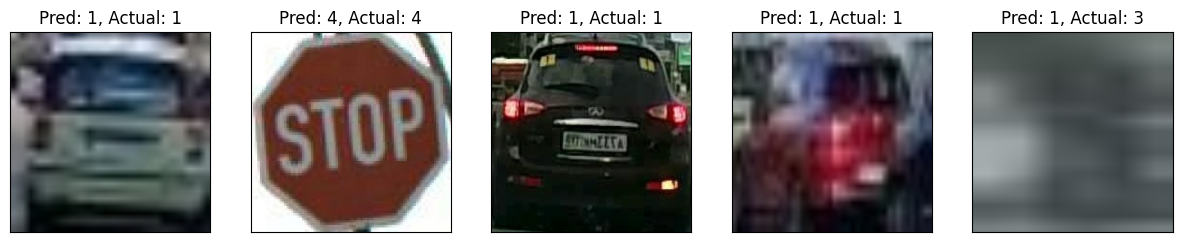

In [51]:
def visualize_predictions_with_images(test_dataset, model, num_images=5):
    # Create an iterator for the dataset
    dataset_iter = iter(test_dataset)

    # Display 'num_images' sets of images
    for i in range(num_images):
        # Get a batch of images and labels
        image_batch, label_batch = next(dataset_iter)

        # Predict the labels using the trained model
        predictions = model.predict(image_batch)

        # Assuming you want to plot a maximum of 5 images from a batch
        num_to_display = min(5, image_batch.shape[0])  # Handle less than 5 images if batch size is smaller

        plt.figure(figsize=(15, 15))  # Adjust the figure size based on your layout preference
        for j in range(num_to_display):
            plt.subplot(1, num_to_display, j + 1)  # Adjust subplot layout based on number of images
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(image_batch[j])
            predicted_label = np.argmax(predictions[j])
            actual_label = np.argmax(label_batch[j])
            plt.title(f"Pred: {predicted_label}, Actual: {actual_label}")

        plt.show()

# Example usage
visualize_predictions_with_images(test_dataset, model, num_images=1)